# **Assignment 9A:**

**Part1**
 1. Take your 6A Code (your optimized version, not the base version with Dense layer), and learn how to integrate gradCAM with your code. Learn more about gradCAM here. (Links to an external site.) 
2. As proof of integration, test 4 images (remember the image ids or names) from your network and show the visualization like this: enter image description here
3. This is the first part of the assignment. 

**Part 2**
1. Train your 6A model again, but this time add CutOut. Use this link (Links to an external site.) for reference. 
2. Show the same 4 images again with gradCAM's result. 
3. This is the second part of the assignment

Submit the file as Assignment 9

**Pending 1: Need to figure out why gradCam is just turning blue for the whole image.**

**Pending 2: Selecting 4 specific images from the data set and showing gradCam before and after cutout. (Current implimentation shows gradcam for 10 randomly selected images from data set. )**

Importing al necessary keras, matplot, numpy libs

In [40]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

#geting repo for eraser 
!git clone https://github.com/yu4u/cutout-random-erasing ./random_eraser 
import sys
sys.path.append("/content/random_eraser/")

Cloning into './random_eraser'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23
Unpacking objects: 100% (23/23), done.


In [3]:
#preparing check point for saving weights via callback
from google.colab import drive
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing, loading data in train and test

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

Viewsing train data for labels.

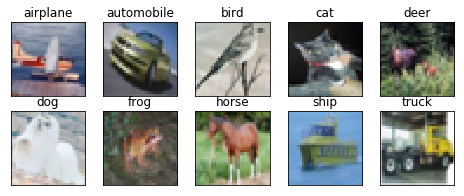

In [30]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Defigning function to plot model training validation accuracy and loss

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Defining function to find and return accracy of trained model in percentage

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Normalizing train and test data 
Converting labels from 1-D to 2-D with leangth of second dimention is num_class

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Defigning Model and Compiling Model

Applying step 2 changes.

In [43]:
# Define the model
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3))) #RF 3X3
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(48, 3, 3, border_mode='same')) #RF 5X5
model.add(Activation('relu'))
model.add(BatchNormalization())

#creating bottel neck
model.add(Convolution2D(24, 1, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #RF 10X10
#Dropout post maxpooling is not help ful; should move this to conv with 14x14
#model.add(Dropout(0.25))

model.add(Convolution2D(96, 3, 3, border_mode='same')) #RF 12X12
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(96, 3, 3, border_mode='same')) #RF 14X14
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.25))

#creating bottel neck
model.add(Convolution2D(48, 1, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #RF 28X28
#Dropout post maxpooling is not help ful; should move this to conv with 30x30
#model.add(Dropout(0.25))

model.add(Convolution2D(192, 3, 3, border_mode='same')) #RF 30X30
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.25))

model.add(Convolution2D(192, 3, 3, border_mode='same')) #RF 32X32
model.add(Activation('relu'))
model.add(BatchNormalization())

# Creating bottle neck
model.add(Convolution2D(96, 1, 1, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #RF 64X64
model.add(Dropout(0.25))


'''
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
'''

model.add(Convolution2D(10, 1)) 
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(10, 4)) 


model.add(Flatten())
model.add(Activation('softmax'))

#Adding lr rate scheduling and model saving
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
def scheduler(epoch, lr):
  return round(0.01 * 1/(1 + 0.319 * epoch), 10)

filepath="/content/gdrive/My Drive/Weights/Assignment9A_weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callback_list = [LearningRateScheduler(scheduler, verbose=1), checkpoint]

# Compile the model
model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (1, 1), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarnin

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 48)        20784     
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 48)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 48)        192       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 24)        1176      
__________

Training for Epochs = 20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=20)`
  del sys.path[0]
W0630 16:47:58.211502 140136733288320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprec

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
390/390 [==============================] - 18s 46ms/step - loss: 1.4313 - acc: 0.4766 - val_loss: 2.1792 - val_acc: 0.4463

Epoch 00001: val_acc improved from -inf to 0.44630, saving model to /content/gdrive/My Drive/Weights/Assignment9A_weights-improvement-01-0.4463.hdf5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0075815011.
390/390 [==============================] - 14s 37ms/step - loss: 0.9965 - acc: 0.6449 - val_loss: 1.0453 - val_acc: 0.6361

Epoch 00002: val_acc improved from 0.44630 to 0.63610, saving model to /content/gdrive/My Drive/Weights/Assignment9A_weights-improvement-02-0.6361.hdf5
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0061050061.
390/390 [==============================] - 14s 36ms/step - loss: 0.8178 - acc: 0.7109 - val_loss: 1.0828 - val_acc: 0.6394

Epoch 00003: val_acc improved from 0.63610 to 0.63940, saving model to /conte

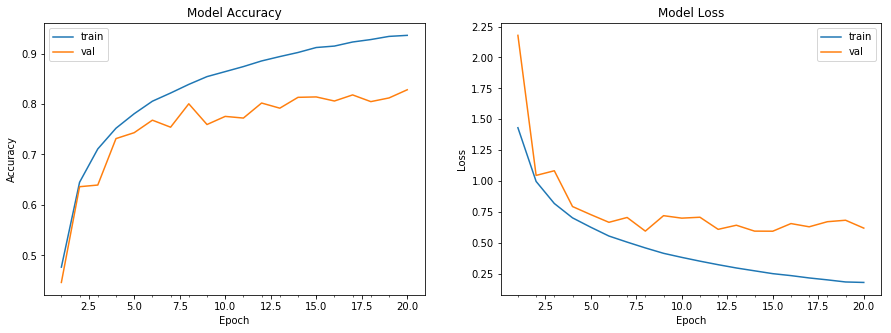

Accuracy on test data is: 82.83


In [11]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 20, 
                                 validation_data = (test_features, test_labels), verbose=1, 
                                 callbacks=callback_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Integrating gradCAM

In [0]:
# Importing necessary Packages for Grad Cam
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


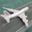

GradCam


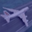

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


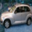

GradCam


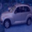

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


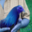

GradCam


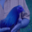

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


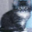

GradCam


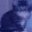

Original


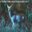

GradCam


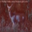

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


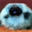

GradCam


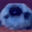

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


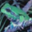

GradCam


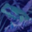

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


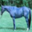

GradCam


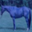

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


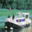

GradCam


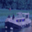

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


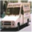

GradCam


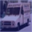

-1

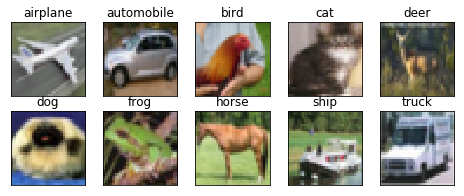

In [36]:
from google.colab.patches import cv2_imshow

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))

for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    #print (idx)
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
    #print (img_num)
    #print (class_names[i])
    
    # Loading/Preparing images for gradCAM execution
    x = image.img_to_array(im)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    
    #last convolution layer for current model is conv2d_11 
    last_conv_layer = model.get_layer("conv2d_11") 
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    #print (grads)
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
      
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (im.shape[1], im.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = cv2.addWeighted(im, 0.6, heatmap, 0.4, 0)
    
    print ("Original")
    cv2_imshow(im)
    #plt.imshow(im)
    print ("GradCam")
    cv2_imshow(superimposed_img)
    #plt.imshow(superimposed_img)
    
cv2.waitKey(0)
#plt.show()

Part 2: adding CutOut

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
  2/390 [..............................] - ETA: 22s - loss: 2.3024 - acc: 0.1133

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=20)`


390/390 [==============================] - 14s 37ms/step - loss: 1.6029 - acc: 0.4022 - val_loss: 3.8639 - val_acc: 0.1000

Epoch 00001: val_acc did not improve from 0.83360
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0075815011.
390/390 [==============================] - 14s 37ms/step - loss: 1.0297 - acc: 0.6321 - val_loss: 2.4902 - val_acc: 0.2794

Epoch 00002: val_acc did not improve from 0.83360
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0061050061.
390/390 [==============================] - 15s 37ms/step - loss: 0.8416 - acc: 0.7030 - val_loss: 0.8718 - val_acc: 0.6930

Epoch 00003: val_acc did not improve from 0.83360
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.005109862.
390/390 [==============================] - 14s 37ms/step - loss: 0.7480 - acc: 0.7369 - val_loss: 0.7281 - val_acc: 0.7481

Epoch 00004: val_acc did not improve from 0.83360
Epoch 5/20

Epoch 00005: LearningRateScheduler 

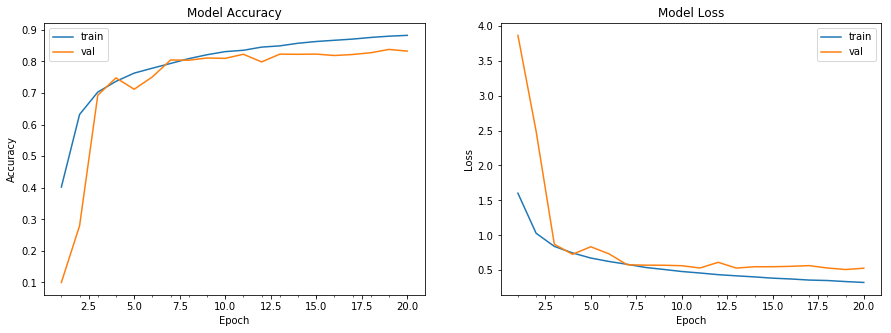

Accuracy on test data is: 83.29


In [55]:
from keras.preprocessing.image import ImageDataGenerator

# importing lib for cutout
from random_eraser import get_random_eraser

# Adding cutout function as guided in the documentation of https://github.com/yu4u/cutout-random-erasing
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False, preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 20, 
                                 validation_data = (test_features, test_labels), verbose=1, 
                                 callbacks=callback_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

gradCAM post cutout

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


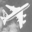

GradCam


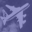

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


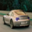

GradCam


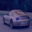

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


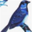

GradCam


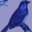

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


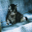

GradCam


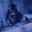

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


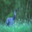

GradCam


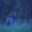

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


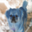

GradCam


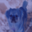

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


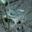

GradCam


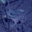

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


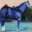

GradCam


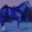

Original


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


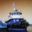

GradCam


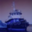

Original


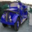

GradCam


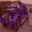

-1

In [57]:
from google.colab.patches import cv2_imshow

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
#fig = plt.figure(figsize=(8,3))

for i in range(num_classes):
    #ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    #print (idx)
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
   # plt.imshow(im)
    #print (img_num)
    #print (class_names[i])
    
    # Loading/Preparing images for gradCAM execution
    x = image.img_to_array(im)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    
    #last convolution layer for current model is conv2d_11 
    last_conv_layer = model.get_layer("conv2d_22") 
    
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    #print (grads)
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(10):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
      
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (im.shape[1], im.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = cv2.addWeighted(im, 0.6, heatmap, 0.4, 0)
    
    print ("Original")
    cv2_imshow(im)
    #plt.imshow(im)
    print ("GradCam")
    cv2_imshow(superimposed_img)
    #plt.imshow(superimposed_img)
    
cv2.waitKey(0)
#plt.show()